# **Laboratorio 5:** Despliegue

## 1. Descargar el dataset e instalar librerías

Esta vez, usaremos el dataset MNIST desde la librería Scikit-learn, el cual es muy usado por la comunidad para primeros experimentos de Deep Learning y Machine Learning para reconocimiento de imágenes.


In [2]:
# Importar librerías
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss, confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay

import mlflow

In [3]:
from sklearn.datasets import fetch_openml
# Descargar dataset mnist
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

/Users/edwinsalcedo/opt/anaconda3/envs/deployment/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


#### Mostrar instancias

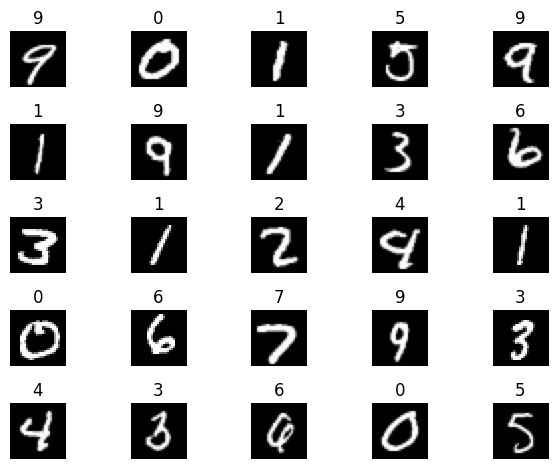

In [4]:
def plot_samples(num_samples=25, subset_images=None, subset_labels=None):
	'''
		Esta función recibe como atributo a un conjunto de muestras en formato numpy,
		y las muestra en una cuadricula usando matplotlib.
	'''
	# Definir el tamaño de la figura a generarse con Matplotlib
	fig = plt.figure(dpi=100)
	# Mostrar una muestra de n imágenes
	for ix in range(num_samples):
		ax = plt.subplot(5, 5, ix + 1)

		# Seleccionar aleatoriamente un indice del subconjunto de entrenamiento
		i = random.randint(0, len(subset_images)-1)
		# Extraer la imagen y etiqueta
		img, label = subset_images[i], subset_labels[i]
		# Plotear la imagen y agregar la etiqueta como titulo
		ax.imshow(img, cmap='gray')
		ax.set_title(label)
		# Eliminar ejes horizontales y verticales
		ax.axis('off')
	# Ajustar el espacio entre los sub graficos
	plt.tight_layout()
	plt.show()


plot_samples(25, X.reshape(len(X),28,28), y)

## 3. Machine Learning

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

def split_preprocess_dataset(X, y):
    # Normalizar valores de pixeles
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # Dividir el dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=10000, random_state=0)

    # Mostrar la longitud de los subconjuntos y sus anotaciones.
    print("Tamaños de subconjuntos X_train:",len(X_train),"X_test:", len(X_test), "y_train:", len(y_train),"y_test:", len(y_test))
    return X_train, X_test, y_train, y_test, scaler

def training_classifier(X_train, y_train):
    n_splits = 5
    model = MLPClassifier(hidden_layer_sizes=(300,))
    model.fit(X_train, y_train)

    return model

def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

def get_metrics(y_true, y_pred, y_pred_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="micro")
    recall = recall_score(y_true, y_pred, average="micro")
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

def create_confusion_matrix_plot(y_test, y_pred, labels):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=labels)
    plt.savefig('../ml/confusion_matrix.png')

In [8]:
# Preprocesamiento y entrenamiento
def preprocess_train(X, y):
    X_train, X_test, y_train, y_test, scaler = split_preprocess_dataset(X, y)
    model = training_classifier(X_train,y_train)
    return model, X_train, X_test, y_train, y_test, scaler

model, X_train, X_test, y_train, y_test, scaler = preprocess_train(X, y)

Tamaños de subconjuntos X_train: 60000 X_test: 10000 y_train: 60000 y_test: 10000


Predicciones con el subconjunto de evaluación:
['0' '4' '1' ... '1' '3' '0']
Dist. de probabilidades de predicción con el subconjunto de evaluación:
[[9.99996561e-01 8.33792748e-26 4.52264592e-12 ... 8.65191442e-15
  2.83017561e-11 4.69987332e-08]
 [4.00199066e-21 6.35056820e-20 1.30913764e-16 ... 1.18387801e-11
  2.29624949e-16 5.09865087e-13]
 [5.22326410e-16 9.99994546e-01 2.13927966e-11 ... 4.43825262e-08
  2.60442250e-07 4.61862784e-06]
 ...
 [1.41671008e-13 9.99999318e-01 1.05882691e-08 ... 6.68412310e-07
  2.54409259e-09 1.22198207e-12]
 [1.75720835e-20 1.74425003e-16 9.27540417e-17 ... 1.89915295e-17
  7.55769266e-14 2.16633150e-13]
 [1.00000000e+00 2.92894764e-25 7.23093399e-13 ... 3.75597340e-11
  2.53478871e-15 5.38579074e-11]]
Métricas del modelo:


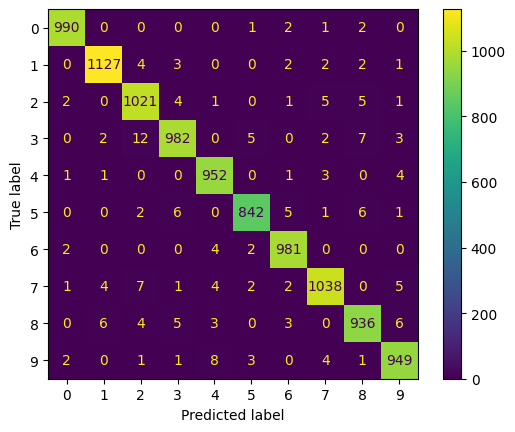

In [9]:
# Inferencia y evaluación
def predict_evaluate(model, X_test, y_test):
  print("Predicciones con el subconjunto de evaluación:")
  y_pred = predict_on_test_data(model, X_test)
  print(y_pred)
  print("Dist. de probabilidades de predicción con el subconjunto de evaluación:")
  y_pred_prob = predict_prob_on_test_data(model, X_test) #model.predict_proba(X_test)
  print(y_pred_prob)
  print("Métricas del modelo:")
  run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
  create_confusion_matrix_plot(y_test, y_pred, model.classes_)

  return run_metrics

run_metrics = predict_evaluate(model, X_test, y_test)

## 4. Guardar modelo y transformer para su despliegue

In [10]:
filename = "../ml/MLP.pkl"
pickle.dump(model, open(filename, "wb"))

filename = "../ml/scaler.pkl"
pickle.dump(scaler, open(filename, "wb"))